In [247]:
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"Version :{torch.__version__}")

Version :2.0.0+cpu


In [248]:
train_data = datasets.FashionMNIST(
    root="data",
    transform=ToTensor(),
    train=True,
    download=True,
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    transform=ToTensor(),
    train=False,
    download=True,
)

In [249]:
test_data.data[0].unsqueeze(dim=0).shape

torch.Size([1, 28, 28])

In [250]:
len(test_data.data)

10000

In [251]:
class_names = test_data.classes

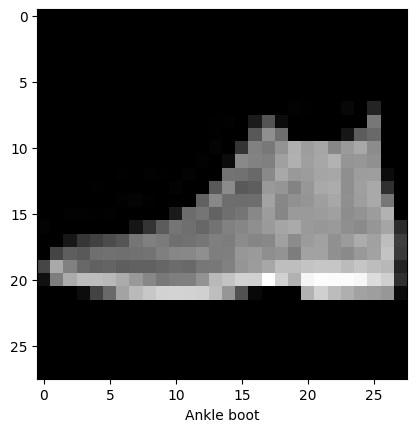

In [252]:
sample_image, sample_target = test_data.data[0], test_data.targets[0]

plt.imshow(sample_image, cmap="gray")
plt.xlabel(class_names[sample_target]);

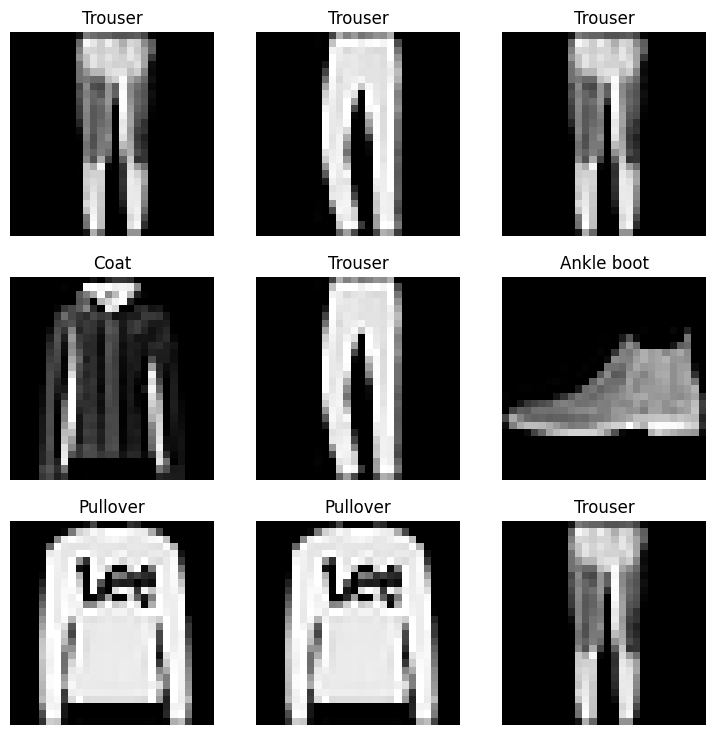

In [253]:
import numpy as np

np.random.seed(82)

figsize = (9, 9)
n_rows, n_cols = 3, 3
fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
ax = ax.flatten()

samples_image, samples_label = test_data.data, test_data.targets

for i in range(n_rows * n_cols):
    ridx = np.random.randint(n_rows * n_cols)
    cur_ax = ax[i]
    
    cur_ax.imshow(samples_image[ridx], cmap="gray")
    cur_ax.set_title(class_names[samples_label[ridx]])
    cur_ax.axis(False)

In [254]:
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(train_data,
                           batch_size = batch_size,
                           shuffle = True)

test_dataloader = DataLoader(test_data,
                           batch_size = batch_size,
                           shuffle = False)

In [255]:
print(f"Data loader {train_dataloader}")
print(f"Size of train data: {len(train_dataloader)} per {batch_size}")
print(f"Size of test data: {len(test_dataloader)} per {batch_size}")

Data loader <torch.utils.data.dataloader.DataLoader object at 0x0000025526932640>
Size of train data: 1875 per 32
Size of test data: 313 per 32


In [256]:
sample_image, _ = next(iter(test_dataloader))

In [257]:
flatten_layer = nn.Flatten()

flatten_layer(sample_image[0]).shape

torch.Size([1, 784])

In [258]:
class FashionModelV0(nn.Module):
    def __init__(self, in_samples: int, out_class: int, hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_samples, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=out_class)
        )
        
    def forward(self, X):
        return self.layer_stack(X)
        
        

In [259]:
model_1 = FashionModelV0(in_samples=784, out_class=10, hidden_units=64)
model_1

FashionModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [260]:
torch.softmax(model_1(sample_image[0]), dim=1).argmax(dim=1)

tensor([8])

In [261]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=.01)

In [262]:
def accuracy_fn(y_pred, y_true):
    return (y_pred == y_true).sum() / len(y_true)

acc_fn = accuracy_fn

In [263]:
def print_train_time(start: float, end: float, device: torch.device = None):
    
    total_time = end - start
    print(f"Train on device {device}: {total_time:.4f}")
    return total_time

In [264]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

epochs = 4

start_train_time = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------\n")

    model_1.train()
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        y_pred = model_1(X)
        loss = loss_fn(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        if batch % 400 == 0:
            print(f"Trained {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
        
    train_loss /= len(train_dataloader)
    
    model_1.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        
        for batch, (X, y) in enumerate(test_dataloader):
            y_prob = torch.softmax(model_1(X), dim=1)
            y_pred = y_prob.argmax(dim = 1)

            loss = loss_fn(y_prob, y)
            acc = acc_fn(y_pred, y)
            
            test_loss += loss
            test_acc += acc
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"Train loss {train_loss:.4f} | Test loss {test_loss:.4f}, Accuracy test {test_acc:.4f}\n")
    
end_train_time = timer()

_ = print_train_time(start=start_train_time,
                     end=end_train_time)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
----------

Trained 0/60000 samples.
Trained 12800/60000 samples.
Trained 25600/60000 samples.
Trained 38400/60000 samples.
Trained 51200/60000 samples.
Train loss 0.8603 | Test loss 1.7822, Accuracy test 0.7808

Epoch: 1
----------

Trained 0/60000 samples.
Trained 12800/60000 samples.
Trained 25600/60000 samples.
Trained 38400/60000 samples.
Trained 51200/60000 samples.
Train loss 0.5534 | Test loss 1.7367, Accuracy test 0.8047

Epoch: 2
----------

Trained 0/60000 samples.
Trained 12800/60000 samples.
Trained 25600/60000 samples.
Trained 38400/60000 samples.
Trained 51200/60000 samples.
Train loss 0.4969 | Test loss 1.7083, Accuracy test 0.8250

Epoch: 3
----------

Trained 0/60000 samples.
Trained 12800/60000 samples.
Trained 25600/60000 samples.
Trained 38400/60000 samples.
Trained 51200/60000 samples.
Train loss 0.4699 | Test loss 1.6964, Accuracy test 0.8309

Train on device None: 29.6170


In [265]:
def train_loop(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accurency_fn,
               device: torch.device = device):
    
    
    total_loss = 0
    total_acc = 0
    model.to(device)
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        y_pred = model_2(X)
        loss = loss_fn(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = accurency_fn(y_pred.argmax(dim = 1), y)
        
        total_loss += loss
        total_acc += acc
        
    total_loss /= len(dataloader)
    total_acc /= len(dataloader)
    print(f"Train loss {total_loss:.4f} | Train accuracy {total_acc:.4f}")
    
    return {"train_loss": total_loss, "train_acc": total_acc}
        
    
def test_loop(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accurency_fn,
               device: torch.device = device):
    
    total_loss = 0
    total_acc = 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model_2(X)
            loss = loss_fn(y_pred, y)
            acc = accurency_fn(y_pred.argmax(dim = 1), y)
            
            total_loss += loss
            total_acc += acc

        total_loss /= len(dataloader)
        total_acc /= len(dataloader)
        print(f"Test loss {total_loss:.4f} | Test accuracy {total_acc:.4f}")

    return {"test_loss": total_loss, "test_acc": total_acc}

    
        

In [266]:
class FashionModelV1(nn.Module):
    def __init__(self, in_samples, hidden_units, out_class):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_samples, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_class),
            nn.ReLU()
        )
        
    def forward(self, X):
        return self.layer_stack(X)

In [267]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [268]:
model_2 = FashionModelV1(in_samples = 784, 
                         hidden_units = 64,
                         out_class = 10)
model_2

FashionModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [269]:
loss_fn_2 = nn.CrossEntropyLoss()

optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=.01)

In [270]:
epochs = 4

start_train_time = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------\n")

    train_loop(model=model_2, 
               dataloader=train_dataloader,
               loss_fn=loss_fn_2,
               optimizer=optimizer_2,
               accurency_fn=acc_fn)
    
    test_loop(model=model_2, 
             dataloader=train_dataloader,
             loss_fn=loss_fn_2,
             accurency_fn=acc_fn)
    
end_train_time = timer()

_ = print_train_time(start=start_train_time,
                     end=end_train_time,
                     device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
----------

Train loss 1.1704 | Train accuracy 0.6546
Test loss 0.8629 | Test accuracy 0.7415
Epoch: 1
----------

Train loss 0.7976 | Train accuracy 0.7541
Test loss 0.7450 | Test accuracy 0.7648
Epoch: 2
----------

Train loss 0.7217 | Train accuracy 0.7694
Test loss 0.7000 | Test accuracy 0.7755
Epoch: 3
----------

Train loss 0.6860 | Train accuracy 0.7771
Test loss 0.6760 | Test accuracy 0.7786
Train on device cpu: 46.9717


In [271]:
def eval_model(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    model.to(device)
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.inference_mode():
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_pred.argmax(dim = 1), y)

        total_loss += loss
        total_acc += acc

      total_loss /= len(dataloader)  # len(dataloader): n_iterations == total_samples / batch_size
      total_acc /= len(dataloader)

    return {"model_name": model.__class__.__name__,
            "loss_score": total_loss.item(),
            "accuracy_score": total_acc.item()}


In [272]:
eval_model_2 = eval_model(model=model_2,
                           dataloader=test_dataloader,
                           loss_fn=loss_fn_2,
                           accuracy_fn=acc_fn)
eval_model_2

{'model_name': 'FashionModelV1',
 'loss_score': 0.7112070322036743,
 'accuracy_score': 0.7661741375923157}

In [285]:
eval_model_1 = eval_model(model=model_1,
                           dataloader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=acc_fn)
eval_model_V1 = eval_model_1

# CNN Model

In [274]:
class FashionModelV2(nn.Module):
    def __init__(self, in_channels: int, hidden_units: int, out_classes: int):
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=out_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, X):
        X = self.block_1(X)
        X = self.block_2(X)
        return self.classifier(X)
        

In [275]:
torch.manual_seed(42)

model_3 = FashionModelV2(in_channels=1, hidden_units=10, out_classes=10).to(device)
model_3

FashionModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
    (2): Softmax(dim=1)
  )
)

In [282]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

loss_fn_3 = nn.CrossEntropyLoss()

optimizer_3 = torch.optim.SGD(params=model_3.parameters(), lr=.01)

epochs = 4
start_train_time = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n-----------\n")
  train_loop(model=model_3, 
             dataloader=train_dataloader,
             loss_fn=loss_fn_3,
             optimizer=optimizer_3,
             accurency_fn=acc_fn)

  test_loop(model=model_3, 
             dataloader=test_dataloader,
             loss_fn=loss_fn_3,
             accurency_fn=acc_fn)

end_train_time = timer()

total_train_time_V2 = print_train_time(start=start_train_time, end=end_train_time, device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 0
-----------

Train loss 0.6760 | Train accuracy 0.7786
Test loss 0.7112 | Test accuracy 0.7662
Epoch : 1
-----------

Train loss 0.6760 | Train accuracy 0.7786
Test loss 0.7112 | Test accuracy 0.7662
Epoch : 2
-----------

Train loss 0.6760 | Train accuracy 0.7786
Test loss 0.7112 | Test accuracy 0.7662
Epoch : 3
-----------

Train loss 0.6760 | Train accuracy 0.7786
Test loss 0.7112 | Test accuracy 0.7662
Train on device cpu: 28.7009


In [277]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_4 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_4

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [278]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

loss_fn_4 = nn.CrossEntropyLoss()

optimizer_4 = torch.optim.SGD(params=model_4.parameters(), lr=.01)

epochs = 4
start_train_time = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n-----------\n")
  train_loop(model=model_4, 
             dataloader=train_dataloader,
             loss_fn=loss_fn_4,
             optimizer=optimizer_4,
             accurency_fn=acc_fn)

  test_loop(model=model_4, 
             dataloader=test_dataloader,
             loss_fn=loss_fn_4,
             accurency_fn=acc_fn)

end_train_time = timer()

total_train_time_V4 = print_train_time(start=start_train_time, end=end_train_time, device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 0
-----------

Train loss 0.6760 | Train accuracy 0.7786
Test loss 0.7112 | Test accuracy 0.7662
Epoch : 1
-----------

Train loss 0.6760 | Train accuracy 0.7786
Test loss 0.7112 | Test accuracy 0.7662
Epoch : 2
-----------

Train loss 0.6760 | Train accuracy 0.7786
Test loss 0.7112 | Test accuracy 0.7662
Epoch : 3
-----------

Train loss 0.6760 | Train accuracy 0.7786
Test loss 0.7112 | Test accuracy 0.7662
Train on device cpu: 29.5271


In [281]:
eval_model_V2 = eval_model(model=model_3, dataloader=test_dataloader, loss_fn=loss_fn_3, accuracy_fn=acc_fn)
eval_model_V2

{'model_name': 'FashionModelV2',
 'loss_score': 2.3025097846984863,
 'accuracy_score': 0.09994009882211685}

In [280]:
eval_model_V0 = eval_model(model=model_2, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=acc_fn)
eval_model_V0

{'model_name': 'FashionModelV0',
 'loss_score': 0.486748605966568,
 'accuracy_score': 0.8308706283569336}

In [283]:
eval_model_V3 = eval_model(model=model_4, dataloader=test_dataloader, loss_fn=loss_fn_4, accuracy_fn=acc_fn)
eval_model_V3

{'model_name': 'FashionMNISTModelV2',
 'loss_score': 2.3023064136505127,
 'accuracy_score': 0.09994009882211685}

In [289]:
import pandas as pd
df = pd.DataFrame([eval_model_V0, eval_model_V1, eval_model_V2])
df

,model_name,loss_score,accuracy_score
0,FashionModelV0,0.486749,0.830871
1,FashionModelV0,0.486749,0.830871
2,FashionModelV2,2.302510,0.099940


Text(0, 0.5, 'Model')

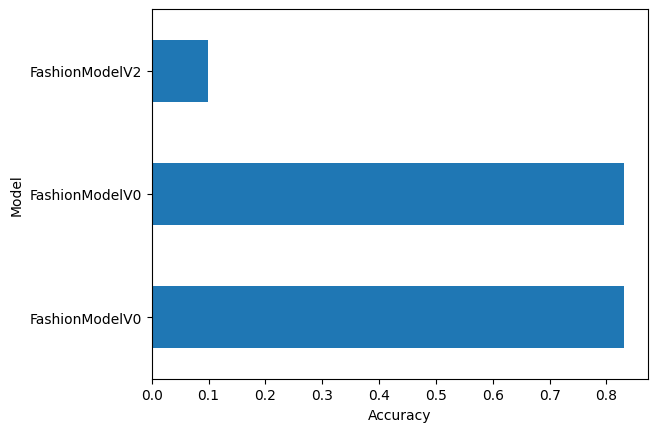

In [288]:
df.set_index("model_name")["accuracy_score"].plot(kind="barh")
plt.xlabel("Accuracy")
plt.ylabel("Model")